# CBS Week 4 Delta Learning and Backpropagation 1

In [8]:

library(neuralnet)
library(testthat)
options(warn=-1)

# Introduction

In many real world situations, we are faced with incomplete or noisy data, and it is important to be able to make reasonable predictions about what is missing from the information available. This can be an especially difficult task when there isn't a good theory available to help reconstruct the missing data. It is in such situations that backpropagation networks may provide some answers.

A beckpropagation network consists of at least three layers of units: an input layer, at least one intermediate hidden layer, and an output layer (see Figure 1). In contrast to the IAC and Hopfield networks, connection weights in a backpropagation network are oneway. Typically, units are connected in a feed-forward fashion with input units fully connected to units in the hidden layer and hidden units fully connected to units in the output layer. When a backrpopagation network is cycled, an input pattern is propagated forward to the output units through the intervening input-to-hidden and hidden-to-output weights.

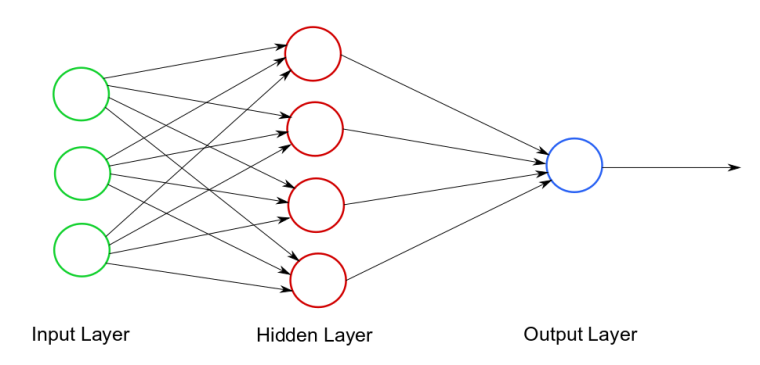

Figure 1: A backpropagation network

We can interpret the output of a backpropagation network as a classification decision. In tutorial 2, we explored how the IAC network can be used to encode and retrieve information about members of two rival gangs (the Jets and the Sharks). For this problem, we could have instead used a backpropagation network to make gang classification judgments (Jets OR Sharks) based on the characteristics of the gang members. However, if we construct the network to predict the gang that is all it does - one can't use the same network to make classifications of marital status or education level as one can with the IAC network.  

Another key difference between the backpropagation and IAC networks is learning. IAC networks have fixed weights, which means that for the Jets and Sharks problem, all of the knowledge about the gang members has to be hard-wired into the network. Backpropagation networks are not limited in this way because they can adapt their weights to acquire new knowledge. In this tutorial, we will explore how backpropagation networks learn by example, and can be used to make predictions.

In backpropagation networks, learning occurs during a __training__ phase in which each input pattern in a training set is applied to the input units and then propagated forward. The pattern of activation arriving at the output layer is then compared with the correct (associated) output pattern to calculate an error signal. The error signal for each such target output pattern is then backpropagated from the outputs to the inputs in order to appropriately adjust the weights in each layer of the network. After a backpropagation network has learned the correct classification for a set of inputs, it can be tested on a second set of inputs, called the __test__ set, to see how well it classifies untrained patterns. Thus, an important consideration in applying backpropagation is how well the network generalizes to the __test__ set.

Before we consider learning, however, lets recap what we learned about how activation is propagated through feedforward networks. In particular, we will code the threshold McCullough Pitts neuron that we discussed in class. 

# Activation Functions

Neural networks use simple processing units. Each unit typically sums its weighted inputs (including the threshold, T):  

$net = \sum_{i} x_i w_i- T$

and then applies an activation function to determine its output:

$f(net)= 
  \begin{cases}
    1,    & \text{if } net \gt 0\\
    0,    & \text{otherwise}
  \end{cases}$

$output = f(net)$

In this case, we have applied a simple threshold activation function but there are many different kinds of functions that have been used. We will introduce another one, called the logistic function (also known as the signmoid function), later when we discuss traning networks. 

Below is the network that we saw in class that implements a logical OR function. The output is 1 if either of the input units are 1. 

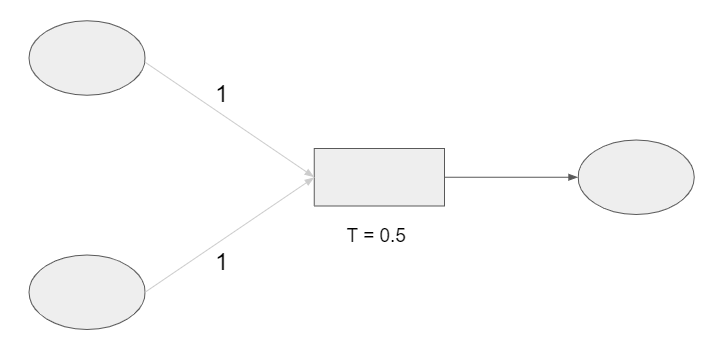

Figure 2: A simple one layer feedforward network with two input units and one output unit.

The code below implements this network in the function __ournet__ and runs it with the inputs (x1 and x2) set to all four possibilities. That is:

* x1 = 0, x2 = 0
* x1 = 0, x2 = 1
* x1 = 1, x2 = 0
* x1 = 1, x2 = 1


In [9]:
w1 = 1
w2 = 1
T = 0.5

ournet = function(x1, x2){
    net = x1 * w1 + x2 * w2 - T
    ifelse(net > 0, 1, 0)
}

ournet(0,0)
ournet(1,0)
ournet(0,1)
ournet(1,1)    

[1] 0

[1] 1

[1] 1

[1] 1

Do the outputs come out as you expect?

Notice the way the ifelse function is used to calculate the output. The function takes three parameters. The first one is an expression that can be either true or false (a boolean expression). The second parameter is the value to return if the expression is true and the third parameter is the value to return if the expression is false.

It is laborious to change each of the inputs by hand, so lets collect these into a dataframe and 
define a function, __test__, that uses a for loop to cycle through them all:

In [10]:
xs = data.frame("x1"=c(0,0,1,1), "x2"=c(0, 1, 0, 1))

test = function(xs){
    outputs = c()
    for (i in 1:4){
        output = ournet(xs$x1[i], xs$x2[i])
        outputs = c(outputs, output)
    }
    data.frame("x1"=xs$x1, "x2"=xs$x2, "output"=outputs)
}

test(xs)

x1,x2,output
<dbl>,<dbl>,<dbl>
0,0,0
0,1,1
1,0,1
1,1,1


## Exercise 1 (1 point)

Change the weights and/or the threshold to alter the function the unit is computing to a logical AND. 

| x1 | x2 | output |
| --- | --- | --- |
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Run test(xs) again to see if it works.

In [11]:
ournet = function(x1, x2){
    net = x1 * w1 + x2 * w2 - T
   ifelse(net > 0, 1, 0)
}


## Exercise 2 (1 point)

Now rewrite the ournet function to implement the XOR function:

| x1 | x2 | output |
| --- | --- | --- |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

Remember that the XOR function requires a two layer network as we demonstrated in the lecture. Again, check that it is doing what it should by running test(xs). 


# Learning in Backpropagation Networks


The neural networks that are used to solve real world problems sometimes have billions of weights and operate on terrabytes of data. Searching for weights by hand is infeasible - hence the need for learning algorithms like backpropagation. The backpropagation algorithm was first proposed by Paul Werbos in the 1970's. However, it wasn't until it was rediscoved in 1986 by Rumelhart and McClelland that backpropagation became widely used.

## Feedforward Dynamics

When a backpropagation network is cycled, the activations of the input units are propagated forward to the output layer through the connecting weights. Like the perceptron, the net input to a unit is determined by the weighted sum of its inputs:

$$
net_j = \sum_i w_{ij} a_i
$$

where $a_i$ is the input activation of unit i and $w_{ij}$ is the weight connecting unit i to unit j. However, instead of calculating a binary output, the net input is added to the unit's bias and the resulting value is passed through a sigmoid function (see Figure 3):

$$
f(net_j) = \frac{1}{1 + e^{-net_j+\theta_j}}
$$

The bias term, $\theta_j$ plays the same role as the threshold in the perceptron. But unlike the binary output of the perceptron, the output of a sigmoid is a continuous real-value between 0 and 1. The sigmoid function is sometimes called a "squashing" function because it maps its inputs, which can range from negative to positive infinity, onto a fixed range.

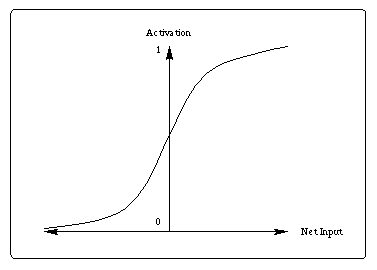

Figure 3: Sigmoid Activation Function

## Gradient Descent


The backpropagation algorithm works by defining an error function which is small when the network is producing outputs that are close to the teacher values and then changing the weights to make the error as low as possible. The most common error function is the sum of squared errors:

$E = \sum_{p} \sum_{j} (t_{pj} - o_{pj})^2$

where $t_{pj}$ is the jth teacher value in the pth pattern and $o_{pj}$ is the jth output value that the network currently produces for the pth pattern. Note that this function is smallest when the $t_{pj} = o_{pj}$ for all p and j.

To train the network, we calculate the gradient of the error function with respect to each weight. 

$$
\frac{\partial E}{\partial w_{ij}}
$$
 
Figure 4 illustrates the concept of gradient descent using a single weight. By adjusting each weight in the opposite direction to the gradient, we can make the error smaller. In this simple example, if we are on the right hand side of the minimum where the gradient is positive, we want to move our weight down. If we are on the left hand side of the minimum where the weight is negative, we want to move the weight up. We make small changes like this to all of the weights over and over until the error no longer decreases - that is we have made the outputs of the network as close to the required outputs as we can.

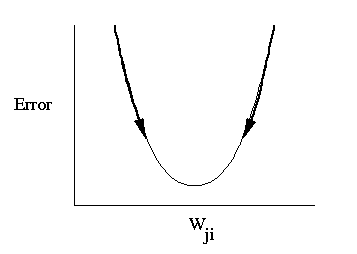

Figure 4: Typical curve showing relationship between overall error and changes in a single weight in a network (reproduced from McClelland and Rumelhart, 1988).

 

The gradient of the threshold function with respect to the weights is either 0 or infinite. That's not much use for deciding how to change the weight. The sigmoid function, however, has a useful gradient everywhere.

In the remaining exercises, we will use the __neuralnet__ package to train networks. We will start by training the simple networks we have already been investigating and then will consider a more complicated example in which we will train a network to recognise digits.

To train a network, we first need to set up a dataframe with both the inputs and the desired outputs. Below __df__ contains the input patterns and the teacher for the AND function. 

In [12]:
df = data.frame("x1"=c(0,0,1,1), "x2"=c(0, 1, 0, 1), "teach"=c(0, 0, 0, 1))
df

x1,x2,teach
<dbl>,<dbl>,<dbl>
0,0,0
0,1,0
1,0,0
1,1,1


Next we construct and train the ANN using the function neuralnet. 

__nn = neuralnet(teach~x1+x2, data=df, hidden=0, act.fct="logistic", linear.output=FALSE)__

Lets consider each of the parameters in turn:

__teach~x1+x2__ is a formula indicating that the neural network should try to predict the values in the column __teach__ using the values in __x1__ and __x2__.

__data=df__ indicates that the inputs and the teacher values are in the dataframe called df

__hidden=0__ specifies how many hidden units to use. To begin with, we will train a single layer netowrk, so there will be no hidden units.

__act.fct = "logistic"__ indicates that the network should use the logistic function (also known as the sigmoid function). 

__linear.output=FALSE__ indicates that we want to use the activation function we just specified when calculating outputs.

Go ahead and train the network using the code below.

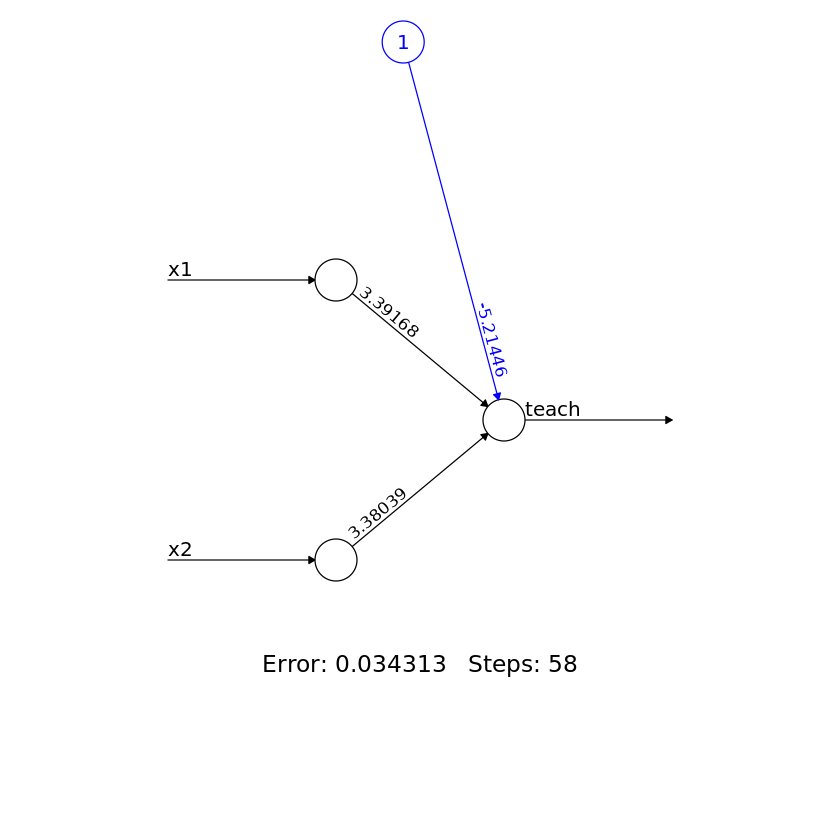

In [13]:
set.seed(5)
nn = neuralnet(teach~x1+x2, data=df, hidden=0, act.fct="logistic", linear.output=FALSE)
plot(nn, rep="best")

Rather than use a threshold as we have done before, the neuralnet package defines a new unit which is always on (see the blue unit and weight). In this way, the algorithm can avoid dealing with the threshold as a special case. It is just another weight to be updated. Note that because the unit is assumed to have a value of one the weight will typically be the negative of the threshold as we defined it previously.

The Error shown at the bottom of the plot of the network is close to 0, so the network is doing a good job of matching the teacher values. In this case, the training algorithm took 64 iterations until the error stopped changing. 

Neural networks are typically initialized with random weights. That means that you can get different solutions each time you run the network. With simple networks like these, sometimes those solutions won't solve the problem at all! The network is said to have fallen into a local minimum. As the error only ever goes down, it never recovers from this situation. Fortunately, when you have networks with many hidden units the problem rarely occurs. In the code above, we have set the random number seed to 5 - so the weights will be initialized to the same values every time and you will get the same final solution. However, if you remove this line and run the network multiple times, you will see that sometimes it does not manage to make the error small.

Now we test the network by supplying the input patterns and seeing what values it produces using the predict function.

In [14]:
test = data.frame("x1"=c(0,0,1,1), "x2"=c(0,1,0,1))
pred = predict(nn, test)
round(pred, 2)

0.01
0.14
0.14
0.83


You can see the output values are not perfectly equal to the teacher values, but they are close.

## Exercise 3 ( 1 point)

Lets convince ourselves that there really is no two layer network that can do the XOR problem. Create a dataframe for the XOR problem and then try training a neural network that has no hidden units to do it. Use the seed 6 and leave the results in the variable pred, so we can automatically test if you have produced the right solution.

## Exercise 4 (1 point)

Now add three hidden units and see how it goes. 

0.00
0.10
0.07
0.86


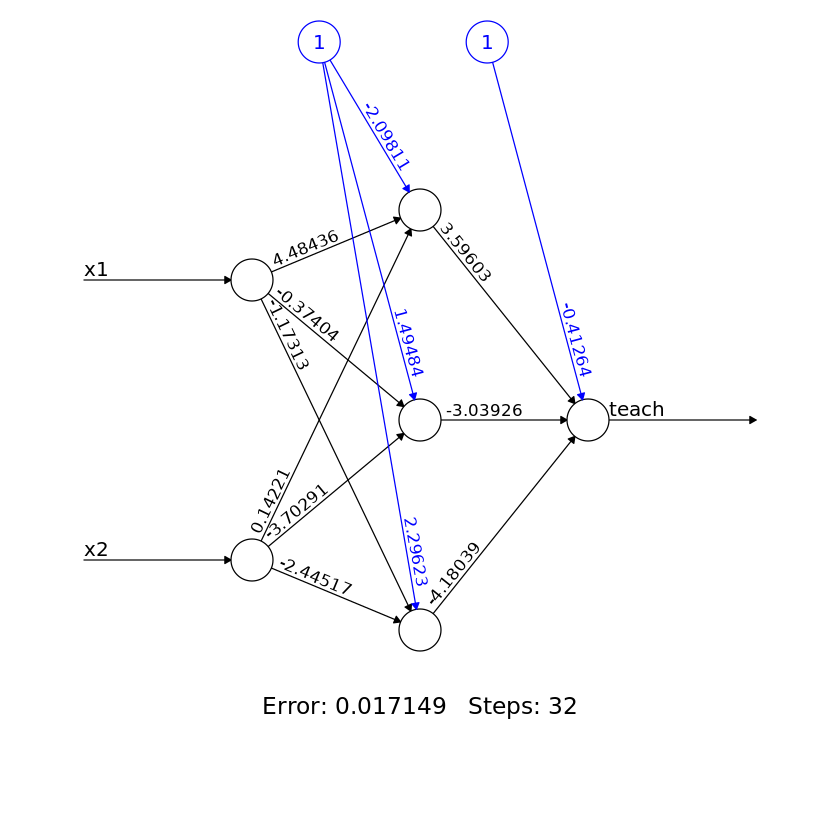

In [23]:
set.seed(5)
nn = neuralnet(teach~x1+x2, data=df, hidden=3, act.fct="logistic", linear.output=FALSE)
plot(nn, rep = 'best')

pred = predict(nn, test)
round(pred, 2)

So far in this tutorial, you saw how to convert the networks that we discussed into code and how to use the neuralnet package in R to train your own networks. In the next section, you will get to train a larger network that recognitizes digits using the same package.  

## Recognising Digits

In this assessment, we are going to construct a neural network for recognising digits. To simplify, we will assume that our digits are presented on an old style calculator. Each digit is a subset of the segments in a figure 8:

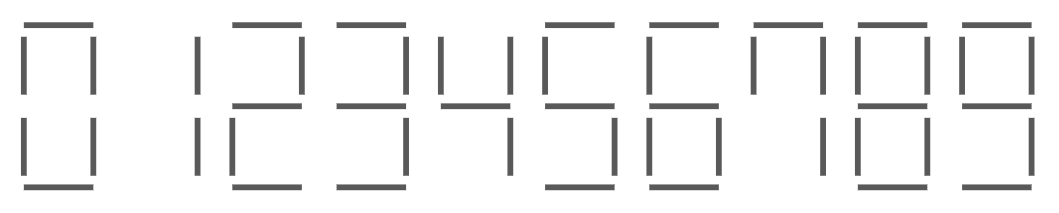



We'll name the segments A through G as follows:

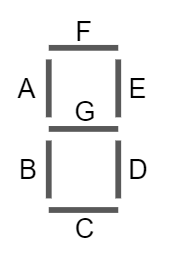

To create an input pattern corresponding to the segments of a given digit we set the active elements to 1 and the inactive elements to 0. For instance, if we are coding the digit 0 we would set all of the elements to 1 except for element G as it does not appear in the display for digit 0. So the input pattern for 0 would be 1 1 1 1 1 1 1 0.

Now instead of having one output unit, we will have one unit corresponding to each digit. The first output pattern then is:

1 0 0 0 0 0 0 0 0 0 

The second output pattern would be:

0 1 0 0 0 0 0 0 0 0

and so on.

We can create the required dataframe as follows:

In [ ]:
digits = data.frame("A"  = c(1, 0, 0, 0, 1, 1, 1, 1, 1, 1),
                    "B"  = c(1, 0, 1, 0, 0, 0, 1, 0, 1, 0),
                    "C"  = c(1, 0, 1, 1, 0, 1, 1, 0, 1, 1),
                    "D"  = c(1, 1, 0, 1, 1, 1, 1, 1, 1, 1),
                    "E"  = c(1, 1, 1, 1, 1, 0, 0, 1, 1, 1),
                    "F"  = c(1, 0, 1, 1, 0, 1, 1, 1, 1, 1),
                    "G"  = c(0, 0, 1, 1, 1, 1, 1, 0, 1, 1),
                    "d0" = c(1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                    "d1" = c(0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
                    "d2" = c(0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
                    "d3" = c(0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
                    "d4" = c(0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
                    "d5" = c(0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
                    "d6" = c(0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
                    "d7" = c(0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
                    "d8" = c(0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
                    "d9" = c(0, 0, 0, 0, 0, 0, 0, 0, 0, 1))
digits

## Exercise 5 (1 point)

Now create a neural network with six hidden units and train it using the neuralnet function (note set the seed to 5 so that the results you get match the responses the automatic marker is looking for).

In [ ]:
# YOUR CODE HERE
stop('No Answer Given!')

Even our relatively simple network has 118 weights! 

## Exercise 6 (1 point)

Now test it to see if it has found a good solution by presenting the inputs and seeing what outputs the network produces. Put the results in the variable __pred__ so the automated marker can find it.

In [ ]:
# YOUR CODE HERE
stop('No Answer Given!')

## Exercise 7  (2 points)

Of course, recalling the patterns is nice, but where neural networks demonstrate their true power is when we give them inputs that they have never seen before. We would like them to make sensible generalisations - just like people do. To test our digit network, let's try presenting the following pattern and see what it thinks it is looking at:

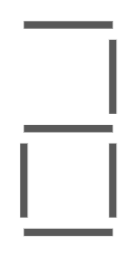

Start by constructing a dataframe that includes the pattern for this input and then present it to see what the network believes it is seeing. Again, put the results in the variable __pred__ so the marker can find it.

In [ ]:
# YOUR CODE HERE
stop('No Answer Given!')

## Exercise 8 (2 points)

The network has made some guesses at the digits. Why do you think it has produced the responses it has?


YOUR ANSWER HERE

You might be starting to appreciate why neural networks have attracted so much attention. If you have a lot of data, can covert it into input patterns and have associated labels, then you can construct a network, run the training algorithm and get it to produce a classifier that not only reproduces what it has seen, but makes intelligence predictions about inputs it has not seen - predictions that often match human performance quite closely.